In [ ]:
# HIDDEN

from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

#### Watch Demo Videos Below

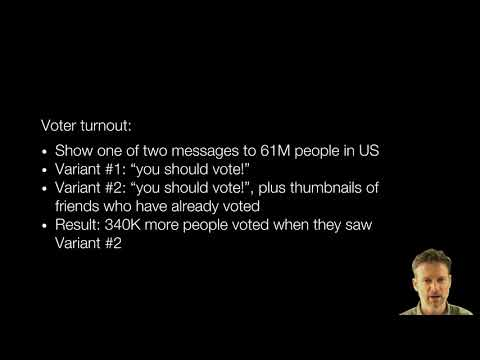

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('8hK6l9Ky2fI', width=800, height=300)

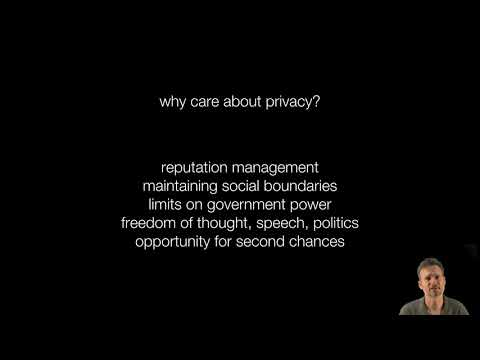

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('I0ksXPao6UA', width=800, height=300)

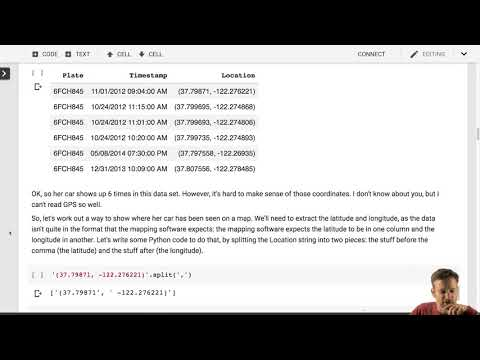

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('bYF6a6N1Ac0', width=800, height=300)

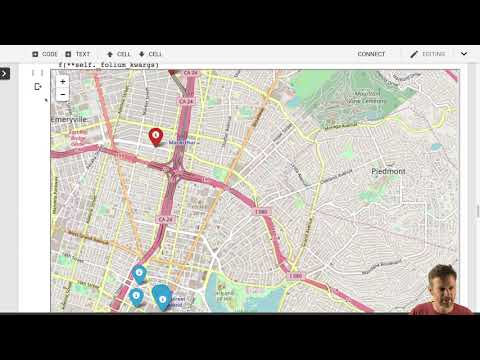

In [4]:
from IPython.display import YouTubeVideo

YouTubeVideo('it8qFBvSy8A', width=800, height=300)

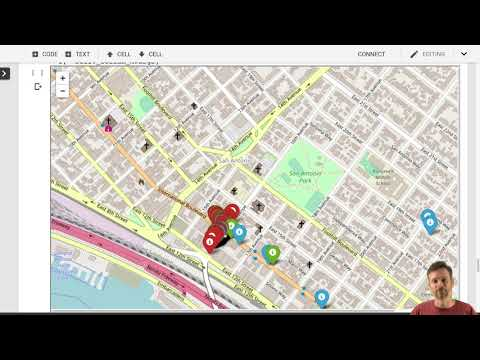

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('vmb6MIlA9j0', width=800, height=300)

## License plates

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('-7haErHby0U', width=800, height=300)

We're going to look at some data collected by the Oakland Police Department. They have automated license plate readers on their police cars, and they've built up a database of license plates that they've seen -- and where and when they saw each one.

## Data collection

First, we'll gather the data.  It turns out the data is publicly available on the Oakland public records site.  I downloaded it and combined it into a single CSV file by myself before lecture.

In [ ]:
lprs = Table.read_table('https://inferentialthinking.com/data/all-lprs.csv.gz', compression='gzip', sep=',')

In [ ]:
lprs

Let's start by renaming some columns, and then take a look at it.

In [ ]:
lprs.relabel('red_VRM', 'Plate')
lprs.relabel('red_Timestamp', 'Timestamp')
lprs

Phew, that's a lot of data: we can see about 2.7 million license plate reads here.

Let's start by seeing what can be learned about someone, using this data -- assuming you know their license plate.

## Searching for Individuals

As a warmup, we'll take a look at ex-Mayor Jean Quan's car, and where it has been seen.  Her license plate number is 6FCH845.  (How did I learn that?  Turns out she was in the news for getting $1000 of parking tickets, and [the news article](http://www.sfgate.com/bayarea/matier-ross/article/Jean-Quan-Oakland-s-new-mayor-gets-car-booted-3164530.php) included a picture of her car, with the license plate visible.  You'd be amazed by what's out there on the Internet...)

In [ ]:
lprs.where('Plate', '6FCH845')

OK, so her car shows up 6 times in this data set.  However, it's hard to make sense of those coordinates.  I don't know about you, but I can't read GPS so well.

So, let's work out a way to show where her car has been seen on a map.  We'll need to extract the latitude and longitude, as the data isn't quite in the format that the mapping software expects: the mapping software expects the latitude to be in one column and the longitude in another.  Let's write some Python code to do that, by splitting the Location string into two pieces: the stuff before the comma (the latitude) and the stuff after (the longitude).

In [ ]:
'(37.79871, -122.276221)'.split(',')

In [ ]:
def get_latitude(s):
    before, after = s.split(',')         # Break it into two parts
    lat_string = before.replace('(', '') # Get rid of the annoying '('
    return float(lat_string)             # Convert the string to a number

def get_longitude(s):
    before, after = s.split(',')                 # Break it into two parts
    long_string = after.replace(')', '').strip() # Get rid of the ')' and spaces
    return float(long_string)                    # Convert the string to a number

Let's test it to make sure it works correctly.

In [ ]:
get_latitude('(37.797558, -122.26935)')

In [ ]:
get_longitude('(37.797558, -122.26935)')

Good, now we're ready to add these as extra columns to the table.

In [ ]:
lprs = lprs.with_columns(
    'Latitude',  lprs.apply(get_latitude, 'Location'),
    'Longitude', lprs.apply(get_longitude, 'Location')
)
lprs

And at last, we can draw a map with a marker everywhere that her car has been seen.

In [ ]:
jean_quan = lprs.where('Plate', '6FCH845').select('Latitude', 'Longitude', 'Timestamp')
Marker.map_table(jean_quan)

OK, so it's been seen near the Oakland police department.  This should make you suspect we might be getting a bit of a biased sample.  Why might the Oakland PD be the most common place where her car is seen?  Can you come up with a plausible explanation for this?

## Poking around

Let's try another.  And let's see if we can make the map a little more fancy.  It'd be nice to distinguish between license plate reads that are seen during the daytime (on a weekday), vs the evening (on a weekday), vs on a weekend.  So we'll color-code the markers.  To do this, we'll write some Python code to analyze the Timestamp and choose an appropriate color.

In [ ]:
import datetime

def get_color(ts):
    t = datetime.datetime.strptime(ts, '%m/%d/%Y %I:%M:%S %p')
    if t.weekday() >= 6:
        return 'green' # Weekend
    elif t.hour >= 6 and t.hour <= 17:
        return 'blue' # Weekday daytime
    else:
        return 'red' # Weekday evening
    
lprs.append_column('Color', lprs.apply(get_color, 'Timestamp'))

Now we can check out another license plate, this time with our spiffy color-coding.  This one happens to be the car that the city issues to the Fire Chief.

In [ ]:
t = lprs.where('Plate', '1328354').select('Latitude', 'Longitude', 'Timestamp', 'Color')
Marker.map_table(t)

Hmm.  We can see a blue cluster in downtown Oakland, where the Fire Chief's car was seen on weekdays during business hours.  I bet we've found her office.  In fact, if you happen to know downtown Oakland, those are mostly clustered right near City Hall.  Also, her car was seen twice in northern Oakland on weekday evenings.  One can only speculate what that indicates.  Maybe dinner with a friend?  Or running errands?  Off to the scene of a fire?  Who knows.  And then the car has been seen once more, late at night on a weekend, in a residential area in the hills.  Her home address, maybe?

Let's look at another. This time, we'll make a function to display the map.

In [ ]:
def map_plate(plate):
    sightings = lprs.where('Plate', plate)
    t = sightings.select('Latitude', 'Longitude', 'Timestamp', 'Color')
    return Marker.map_table(t)
    
map_plate('5AJG153')

What can we tell from this?  Looks to me like this person lives on International Blvd and 9th, roughly.  On weekdays they've seen in a variety of locations in west Oakland.  It's fun to imagine what this might indicate -- delivery person? taxi driver? someone running errands all over the place in west Oakland?

We can look at another:

In [ ]:
map_plate('6UZA652')

What can we learn from this map?  First, it's pretty easy to guess where this person lives: 16th and International, or pretty near there.  And then we can see them spending some nights and a weekend near Laney College.  Did they have an apartment there briefly?  A relationship with someone who lived there?

Is anyone else getting a little bit creeped out about this?  I think I've had enough of looking at individual people's data.

## Inference

As we can see, this kind of data can potentially reveal a fair bit about people.  Someone with access to the data can draw inferences.  Take a moment to think about what someone might be able to infer from this kind of data.
 
As we've seen here, it's not too hard to make a pretty good guess at roughly where some lives, from this kind of information: their car is probably parked near their home most nights.  Also, it will often be possible to guess where someone works: if they commute into work by car, then on weekdays during business hours, their car is probably parked near their office, so we'll see a clear cluster that indicates where they work.

But it doesn't stop there.  If we have enough data, it might also be possible to get a sense of what they like to do during their downtime (do they spend time at the park?).  And in some cases the data might reveal that someone is in a relationship and spending nights at someone else's house.  That's arguably pretty sensitive stuff.

This gets at one of the challenges with privacy.  Data that's collected for one purpose (fighting crime, or something like that) can potentially reveal a lot more.  It can allow the owner of the data to draw inferences -- sometimes about things that people would prefer to keep private.  And that means that, in a world of "big data", if we're not careful, privacy can be collateral damage.

## Mitigation

If we want to protect people's privacy, what can be done about this?  That's a lengthy subject.  But at risk of over-simplifying, there are a few simple strategies that data owners can take:

1. Minimize the data they have.  Collect only what they need, and delete it after it's not needed.

2. Control who has access to the sensitive data.  Perhaps only a handful of trusted insiders need access; if so, then one can lock down the data so only they have access to it.  One can also log all access, to deter misuse.

3. Anonymize the data, so it can't be linked back to the individual who it is about.  Unfortunately, this is often harder than it sounds.

4. Engage with stakeholders.  Provide transparency, to try to avoid people being taken by surprise.  Give individuals a way to see what data has been collected about them.  Give people a way to opt out and have their data be deleted, if they wish.  Engage in a discussion about values, and tell people what steps you are taking to protect them from unwanted consequences.

This only scratches the surface of the subject.  My main goal in this lecture was to make you aware of privacy concerns, so that if you are ever a steward of a large data set, you can think about how to protect people's data and use it responsibly.